<a id="top"></a>
# Team RM5 Classification Predict Notebook
### Kaggle Submission: Team_RM5_SigmoidFreuds <sup>*</sup>
---
<img src="https://github.com/Lizette95/classification-predict-streamlit-template/blob/master/rm5_banner.png?raw=true" align="left">  

**Team Members:** Abednego Pakaree, Iman Mokwena, Lizette Loubser, Omphile Louw, Refiloe Elvis Phipa, Silindokuhle Kubheka    
**Supervisor:** Ridha Moosa

* [Notebook repo](https://github.com/Lizette95/Team_RM5_ClassificationPredict_Notebook)
* [Streamlit repo](https://github.com/Lizette95/classification-predict-streamlit-template)
* [Trello board](https://trello.com/b/pFKnwtGF/classificationteamrm5) 

### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
 * Datasets and Variables
---
2. [Load Dependencies](#imports)
---
3. [Data Cleaning](#cleaning)
 * Load Data
 * Expand Contractions
 * Remove Noise
 * Remove Duplicate Rows
 * Remove Unwanted Columns
 * Tokenize Data
 * Remove Stopwords
---
4. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Label
 * WordClouds
 * Word Counts
---
5. [Data Preprocessing](#preprocessing)
 * Lemmatization
 * Feature Engineering
 * Resampling
 * Split Training and Validation Sets
---
6. [Modelling](#modelling)
---
7. [Performance Evaluation](#evaluation)
---
8. [Model Analysis](#analysis)
---
9. [Conclusion](#conclusion)
---
10. [Save Model and Output](#save)
---

<a id="intro"></a>
## 1. Introduction  

### Background

Machine learning is the study of computer algorithms that improve automatically through experience. It is a powerful branch of Artificial intelligence, dating as far back as 1952. Machine learning algorithms build a mathematical model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to do so.

Classification is a process of categorizing a given set of data into classes, It can be performed on both structured or unstructured data. The process starts with predicting the class of given data points. The classes are often referred to as target, label or categories.


### Problem Statement

Build a classification model that will predict the sentiments of Tweets related to climate change.


### Datasets and Variables

**Datasets:**  
* train.csv: We will use this data to train our model.  
* test.csv: We will use this data to test our model.  

**Variables:**  
* sentiment: Sentiment of tweet  
* message: Tweet body  
* tweetid: Unique Twitter ID  

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:  

| Class | Description                                                                              |
| :----:|:-----------------------------------------------------------------------------------------|
| **2** |**News:** The tweet links to factual news about climate change                            |
| **1** |**Pro:** The tweet supports the belief of man-made climate change                         |
| **0** |**Neutral:** The tweet neither supports nor refutes the belief of man-made climate change |
| **-1**|**Anti:** The tweet does not believe in man-made climate change                           |

<a id="imports"></a>
## 2. Load Dependencies

In [0]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Prerequisites
#import sys
#!{sys.executable} -m pip install wordcloud comet_ml scikit-learn

# Load Dependencies
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud
from gensim.models import Phrases
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")

<a id="cleaning"></a>
## 3. Data Cleaning

### Load Data

In [0]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [0]:
train_data.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [0]:
test_data.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


### Expand Contractions

In [0]:
contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have", "you're": "you are", "you've": "you have"}
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(text):
    """
    Expand contractions using dictionary of contractions.
    """
    text = text.lower()
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

train_data['message'] = train_data['message'].apply(expand_contractions)
test_data['message'] = test_data['message'].apply(expand_contractions)

### Remove Noise

In [0]:
http_regex = re.compile(r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+')
url_regex = re.compile(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)')
rt_regex = re.compile('^(RT|rt)( @\w*)?')
def remove_noise(tweet):
    """
    Remove noise from text data, such as newlines, punctuation, URLs and numbers.
    """
    new_tweet = tweet.replace('\n',' ') #Remove Newlines
    new_tweet = new_tweet.replace('"',' ') #Remove Text Delimeters
    new_tweet = new_tweet.replace('&amp',' ') #Remove Ampersands
    new_tweet = http_regex.sub('', new_tweet) #Remove http URLs
    new_tweet = url_regex.sub('', new_tweet) #Remove other URLs
    new_tweet = rt_regex.sub('', new_tweet) #Remove RTs
    new_tweet = re.sub(r'#(RT|rt)*', '', new_tweet) #Remove RTs
    new_tweet = re.sub(r'@\w*', '', new_tweet) #Remove Mentions
    new_tweet = re.sub('\w*\d\w*','', new_tweet) #Remove Numbers/Words with Numbers
    new_tweet = re.sub('[^a-zA-z\s]', '', new_tweet) #Remove Punctuation
    new_tweet = new_tweet.strip() #Remove Excess Whitespace
    return new_tweet

train_data['message'] = train_data['message'].apply(remove_noise)
test_data['message'] = test_data['message'].apply(remove_noise)

### Remove Duplicate Rows
We can test our models with and without duplicate rows (retweets) to determine if they have an effect on the model's performance. A retweet might be considered as an individual sentiment (wording??).

In [0]:
print('There are ' + str(train_data['message'].duplicated().sum()) + ' duplicate rows in the training set.')
print('There are ' + str(test_data['message'].duplicated().sum()) + ' duplicate rows in the testing set.')

There are 2499 duplicate rows in the training set.
There are 1481 duplicate rows in the testing set.


In [0]:
# Drop duplicate rows/retweets
# train_data = train_data.drop_duplicates(subset='message', keep='first')
# test_data = test_data.drop_duplicates(subset='message', keep='first')

### Remove Unwanted Columns

In [0]:
train_data = train_data.drop('tweetid', axis=1)
train_data['sentiment'] = train_data.pop('sentiment')
train_data.head()

,message,sentiment
0,polyscimajor epa chief does not think carbon d...,1
1,it is not like we lack evidence of anthropogen...,1
2,researchers say we have three years to act on ...,2
3,todayinmaker wired was a pivotal year in the...,1
4,it is and a racist sexist climate change deny...,1


In [0]:
tweetid = test_data['tweetid'] #Save for Output File
test_data = test_data.drop('tweetid', axis=1)
test_data.head()

,message
0,europe will now be looking to china to make su...
1,combine this with the polling of staffers re c...
2,the scary unimpeachable evidence that climate ...
3,putin got to you too jill trump does not bel...
4,female orgasms cause global warming sarcastic ...


### Tokenize Data

In [0]:
train_data['message'] = train_data['message'].apply(word_tokenize)
test_data['message'] = test_data['message'].apply(word_tokenize)

In [0]:
train_data.head()

,message,sentiment
0,"[polyscimajor, epa, chief, does, not, think, c...",1
1,"[it, is, not, like, we, lack, evidence, of, an...",1
2,"[researchers, say, we, have, three, years, to,...",2
3,"[todayinmaker, wired, was, a, pivotal, year, i...",1
4,"[it, is, and, a, racist, sexist, climate, chan...",1


In [0]:
test_data.head()

,message
0,"[europe, will, now, be, looking, to, china, to..."
1,"[combine, this, with, the, polling, of, staffe..."
2,"[the, scary, unimpeachable, evidence, that, cl..."
3,"[putin, got, to, you, too, jill, trump, does, ..."
4,"[female, orgasms, cause, global, warming, sarc..."


### Remove Stopwords

In [0]:
def remove_stopwords(text):
    """
    Remove stopwords from text data.
    """
    stop_words = stopwords.words('english')
    stop_words.extend(['https','via'])
    stop_words = set(stop_words)
    return [word for word in text if not word in stop_words]
    
train_data['message'] = train_data['message'].apply(remove_stopwords)
test_data['message'] = test_data['message'].apply(remove_stopwords)

In [0]:
train_data.head()

,message,sentiment
0,"[polyscimajor, epa, chief, think, carbon, diox...",1
1,"[like, lack, evidence, anthropogenic, global, ...",1
2,"[researchers, say, three, years, act, climate,...",2
3,"[todayinmaker, wired, pivotal, year, war, clim...",1
4,"[racist, sexist, climate, change, denying, big...",1


In [0]:
test_data.head()

,message
0,"[europe, looking, china, make, sure, alone, fi..."
1,"[combine, polling, staffers, climate, change, ..."
2,"[scary, unimpeachable, evidence, climate, chan..."
3,"[putin, got, jill, trump, believe, climate, ch..."
4,"[female, orgasms, cause, global, warming, sarc..."


<a id="EDA"></a>
## 4. Exploratory Data Analysis

### Data Summary

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   sentiment  15819 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 247.3+ KB


In [0]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
dtypes: object(1)
memory usage: 82.5+ KB


---
From the above summaries, we note that:
* None of our datasets have **missing values**
* There is no **sentiment** column in the test data, as this is the **label** that we want to predict
* There are **15 818** entries in our training dataset
* There are **10 545** entries in our testing dataset

After removing retweets, we note that:
* There are **13 316** unique entries in our training dataset
* There are **9 062** unique entries in our testing dataset

### Label
We can examine the number of tweets that fall within a sentiment class and calculate the proportion of tweets that is represented by each class.

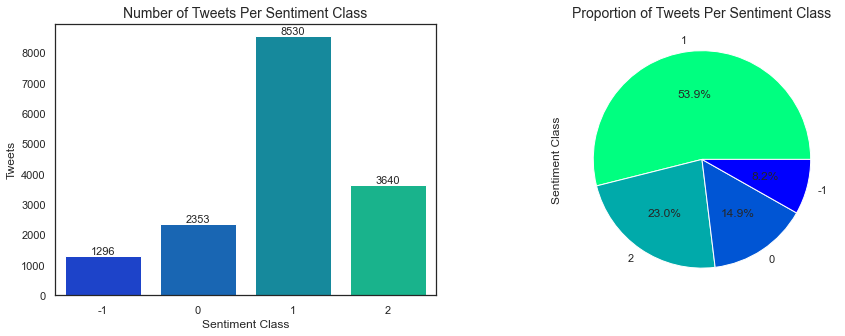

In [0]:
# Number of Tweets Per Sentiment Class
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

ax = sns.countplot(x='sentiment',data=train_data,palette='winter',ax=axis[0])
axis[0].set_title('Number of Tweets Per Sentiment Class',fontsize=14)
axis[0].set_xlabel('Sentiment Class')
axis[0].set_ylabel('Tweets')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')

train_data['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',colormap='winter_r',ax=axis[1])
axis[1].set_title('Proportion of Tweets Per Sentiment Class',fontsize=14)
axis[1].set_ylabel('Sentiment Class')
    
plt.show()

The graphs reveal that our data is imbalanced, as more than 50% of the entries fall within sentiment class "1". This will have to be addressed in the data preprocessing step before building our models.

In [0]:
# Calculate Word Count Per Sentiment Class
train_news = train_data[train_data['sentiment']==2]
train_news['words'] = train_news['message'].apply(lambda x: len(x))

train_pro = train_data[train_data['sentiment']==1]
train_pro['words'] = train_pro['message'].apply(lambda x: len(x))

train_neutral = train_data[train_data['sentiment']==0]
train_neutral['words'] = train_neutral['message'].apply(lambda x: len(x))

train_anti = train_data[train_data['sentiment']==-1]
train_anti['words'] = train_anti['message'].apply(lambda x: len(x))

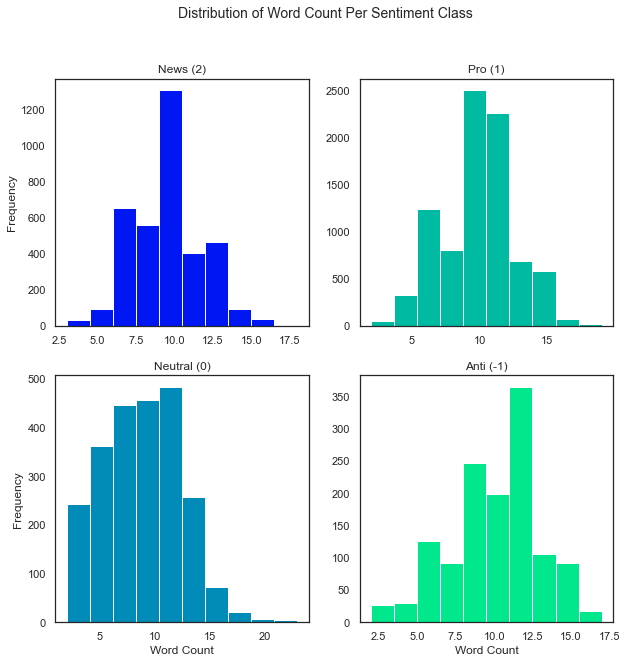

In [0]:
# Distribution of Word Count Per Sentiment Class
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle('Distribution of Word Count Per Sentiment Class', fontsize=14)

axis[0, 0].hist(train_news['words'], bins = 10, color = '#0017F3')
axis[0, 0].set_title('News (2)')
axis[0, 0].set_ylabel('Frequency')

axis[1, 0].hist(train_neutral['words'], bins = 10, color = '#008BB9')
axis[1, 0].set_title('Neutral (0)')
axis[1, 0].set_ylabel('Frequency')
axis[1, 0].set_xlabel('Word Count')

axis[0, 1].hist(train_pro['words'], bins = 10, color = '#00BAA2')
axis[0, 1].set_title('Pro (1)')

axis[1, 1].hist(train_anti['words'], bins = 10, color = '#00E88B')
axis[1, 1].set_title('Anti (-1)')
axis[1, 1].set_xlabel('Word Count')

plt.show()

### WordClouds   
Wordclouds can be used to visualise text data, where the frequency of each word is proportional to the word size.

In [0]:
# Make Wordclouds
def wc(df):
    """
    Join words to create wordclouds.
    """
    words = ''
    for i in df:  
        words += " ".join(i)+" "
    return words
# Training Set
train_words = wc(train_data['message'])
train_wordcloud = WordCloud(width=1500, height=700, background_color='white', colormap='winter', min_font_size=10).generate(train_words)
# Testing Set
test_words = wc(test_data['message'])
test_wordcloud = WordCloud(width=1500, height=700, background_color='white', colormap='winter_r', min_font_size=10).generate(test_words)

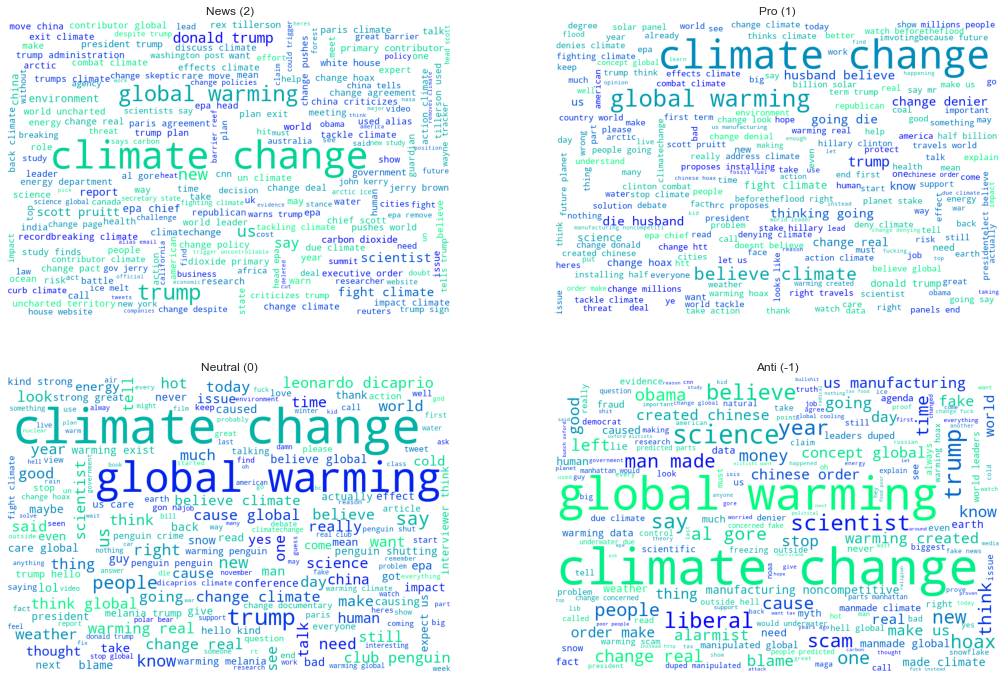

In [0]:
# Wordcloud Per Sentiment Class
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

news = wc(train_news['message'])
news_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter').generate(news)
axis[0, 0].imshow(news_wordcloud)
axis[0, 0].set_title('News (2)')
axis[0, 0].axis("off") 

neutral = wc(train_neutral['message'])
neutral_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter', min_font_size=10).generate(neutral)
axis[1, 0].imshow(neutral_wordcloud)
axis[1, 0].set_title('Neutral (0)')
axis[1, 0].axis("off") 

pro = wc(train_pro['message'])
pro_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter', min_font_size=10).generate(pro)
axis[0, 1].imshow(pro_wordcloud)
axis[0, 1].set_title('Pro (1)')
axis[0, 1].axis("off") 

anti = wc(train_anti['message'])
anti_wordcloud = WordCloud(width=900, height=600, background_color='white', colormap='winter', min_font_size=10).generate(anti)
axis[1, 1].imshow(anti_wordcloud)
axis[1, 1].set_title('Anti (-1)')
axis[1, 1].axis("off") 

plt.show()

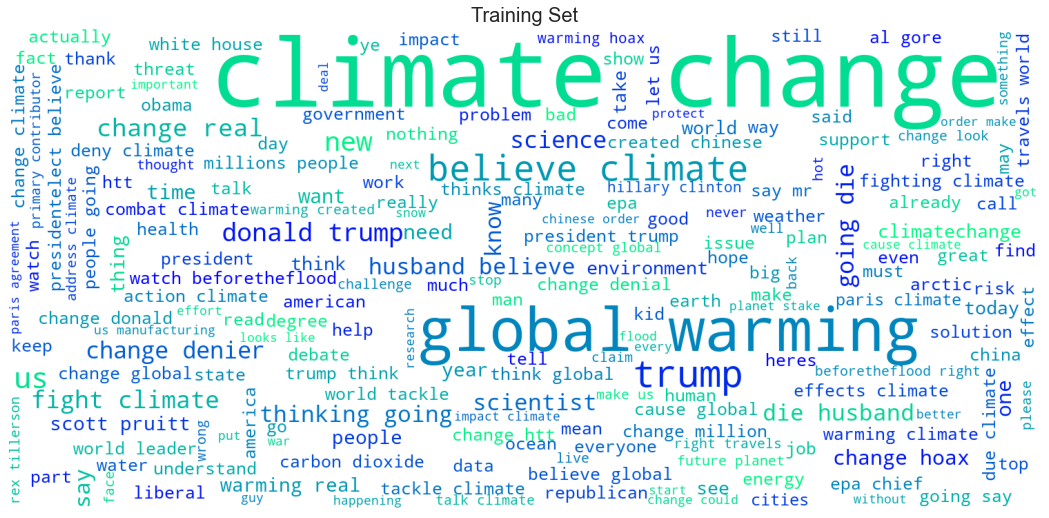

In [0]:
# Wordcloud for Training Data
plt.figure(figsize = (15, 7), facecolor = None) 
plt.title("Training Set",fontsize=20)
plt.imshow(train_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show() 

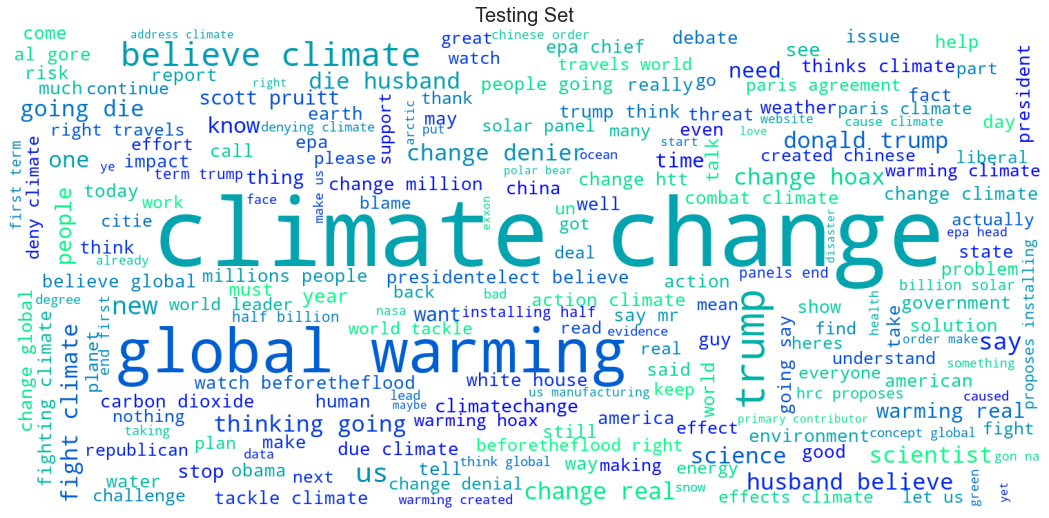

In [0]:
# Wordcloud for Testing Data
plt.figure(figsize = (15, 7), facecolor = None) 
plt.title("Testing Set",fontsize=20)
plt.imshow(test_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

plt.show() 

### Word Counts

In [0]:
def word_counts(text, n):
    """
    Word Counts With Bigrams.
    Ref: https://github.com/robsalgado/personal_data_science_projects/blob/master/mulitclass_text_class/nlp_utils_news.ipynb
    """
    phrases = Phrases(text, min_count=2, threshold=1)
    phrases = list(phrases[text])
    flatten_phrases = [item for phrase in phrases for item in phrase]
    phrases_counts = Counter(flatten_phrases)
    top = phrases_counts.most_common(n)
    word = [i[0] for i in top]
    num = [j[1] for j in top]
    return pd.DataFrame([word, num]).T

In [0]:
# Get Word Frequencies for Top 15 Words Per Sentiment Class
count_news = word_counts(train_news['message'], n=15)
count_pro = word_counts(train_pro['message'], n=15)
count_neutral = word_counts(train_neutral['message'], n=15)
count_anti = word_counts(train_anti['message'], n=15)

df_word_counts = pd.concat([count_news,count_pro,count_neutral,count_anti], axis=1)
df_word_counts.columns = ['News (2)','count','Pro (1)','count','Neutral (0)','count','Anti (-1)','count']
df_word_counts

,News (2),count,Pro (1),count,Neutral (0),count,Anti (-1),count
0,climate_change,2094,climate_change,4117,climate_change,1037,climate_change,605
1,change,789,change,2234,global_warming,683,global_warming,440
2,global_warming,306,global_warming,900,change,286,warming,122
3,trump,270,believe_climate,490,warming,259,change,105
4,us,161,trump,344,trump,98,science,55
5,says,139,real,340,like,78,trump,54
6,warming,97,thinking_going,308,I,75,climate,51
7,donald_trump,95,die_husband,308,us,73,real,50
8,scientists,93,warming,306,people,53,scam,43
9,fight_climate,89,us,243,real,46,hoax,41


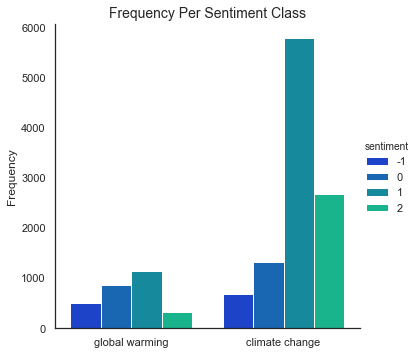

In [0]:
# train = train_data.copy()
# word = []
# for i in train['message']:
#     if "climate change" in i:
#         word.append("climate change")
#     elif "global warming" in i:
#         word.append("global warming")
#     else:
#         word.append("z")
# train['word'] = word
# train = train[~train.word.str.contains("z")]
# sns.factorplot(x='word', hue='sentiment', 
#                     data=train, kind="count", 
#                     palette='winter')
# plt.title('Frequency Per Sentiment Class',fontsize=14)
# plt.xlabel('')
# plt.ylabel('Frequency')
# plt.show()

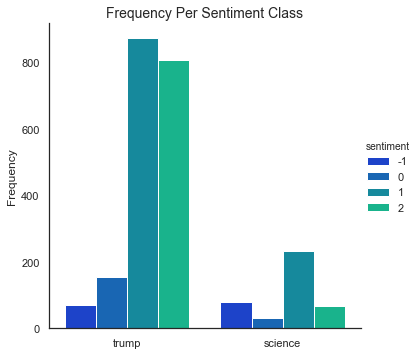

In [0]:
# train = train_data.copy()
# word = []
# for i in train['message']:
#     if "trump" in i:
#         word.append("trump")
#     elif "science" in i:
#         word.append("science")
#     else:
#         word.append(" ")
# train['word'] = word
# train = train[~train.word.str.contains(" ")]
# sns.factorplot(x='word', hue='sentiment', 
#                     data=train, kind="count", 
#                     palette='winter')
# plt.title('Frequency Per Sentiment Class',fontsize=14)
# plt.xlabel('')
# plt.ylabel('Frequency')
# plt.show()

<a id="preprocessing"></a>
## 5. Data Preprocessing

### Lemmatisation

### Feature Engineering

### Resampling

In [0]:
# Class size = roughly half the size of the largest size (i.e. 4000)

### Split Training and Validation Sets

<a id="modelling"></a>
## 6. Modelling

<a id="evaluation"></a>
## 7. Performance Evaluation

<a id="analysis"></a>
## 8. Model Analysis

<a id="conclusion"></a>
## 9. Conclusion

<a id="save"></a>
## 10. Save Model and Output

In [0]:
# Create Kaggle submission file
# final_model = model(parameters)
# final_model.fit(X,y)
# y_test = final_model.predict(X_test)
# results = pd.DataFrame({"tweetid":test_data['tweetid'],"sentiment": y_test})
# results.to_csv("Team_RM5_submission.csv", index=False)

In [0]:
# Save model
# model_save_path = "Team_RM5_model.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(final_model,file)

[Back to top ↑](#top)

<sub>*Team name credit: Ridha (& Freud's mom)</sub>